In [39]:
import numpy as np
import pandas as pd
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

In [40]:
data_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10',download=True, train=True)
data_test = CIFAR10('/home/jupyter/mnt/datasets/cifar10',download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
def show(dataset, num_images = 12):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))

    for i in range(num_images):
        image, label = dataset[i]
        image = np.array(image)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Метка: {label}")

    plt.show()


Train


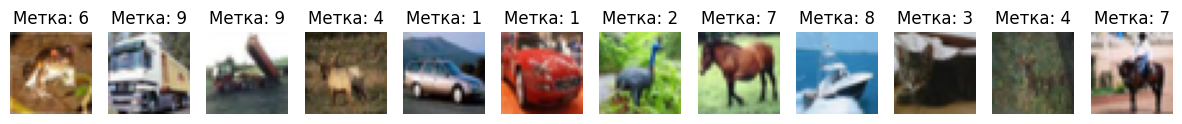

Test


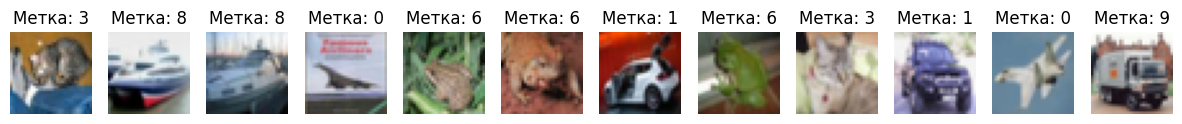

Размеры Trainи: (50000, 32, 32, 3),
Размер Test: (10000, 32, 32, 3)


In [42]:
print("Train")
show(data_train)
print("Test")
show(data_test)

print(f"Размеры Trainи: {data_train.data.shape},")
print(f"Размер Test: {data_test.data.shape}")

In [43]:
def ransform() -> T.Compose:

    means, stds = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]

    trans = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )
    return trans

In [44]:
trans = ransform()
train_data = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=trans)
test_data = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=trans)


In [45]:
img, label = train_data[0]
print(img.shape)

torch.Size([3, 32, 32])


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallVGG, self).__init__()

        # Блок 1: два свёрточных слоя и Max Pooling
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Блок 2: два свёрточных слоя и Max Pooling
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Блок 3: три свёрточных слоя и Max Pooling
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязные слои
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Уменьшено для 32x32
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Блок 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)

        # Блок 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)

        # Блок 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)

        # Выпрямление тензора для полносвязных слоёв
        x = x.view(x.size(0), -1)

        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [47]:
# Инициализация модели, функции потерь и оптимизатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallVGG(num_classes=10)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [48]:
def train(model) -> float:
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for x, y in train_loader:
        bs = y.size(0)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [49]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()
    total_loss = 0
    total = 0
    correct = 0

    for x, y in loader:
        bs = y.size(0)
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        _, y_pred = output.max(dim=1)
        total += y.size(0)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [50]:
def whole_train_valid_cycle(model, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        print(f"Эпоха {epoch+1}")
        print(f"___Train___ Loss = {train_loss}, Accuracy = {train_accuracy}")
        print(f"___Test___  Loss = {valid_loss}, Accuracy = {valid_accuracy}")


In [51]:
my_model = whole_train_valid_cycle(model, 20)

Эпоха 1
___Train___ Loss = 1.5565145524109112, Accuracy = 0.4217
___Test___  Loss = 1.1862328728293157, Accuracy = 0.5692
Эпоха 2
___Train___ Loss = 1.0236299961729123, Accuracy = 0.64244
___Test___  Loss = 0.8920224130533303, Accuracy = 0.6938
Эпоха 3
___Train___ Loss = 0.8132272636341622, Accuracy = 0.71994
___Test___  Loss = 0.7753917113610893, Accuracy = 0.7336
Эпоха 4
___Train___ Loss = 0.680124218963906, Accuracy = 0.76868
___Test___  Loss = 0.7084352668303593, Accuracy = 0.767
Эпоха 5
___Train___ Loss = 0.5887150364306272, Accuracy = 0.80054
___Test___  Loss = 0.7409951958307035, Accuracy = 0.7586
Эпоха 6
___Train___ Loss = 0.5159951909957334, Accuracy = 0.8254
___Test___  Loss = 0.7037546767550669, Accuracy = 0.7694
Эпоха 7
___Train___ Loss = 0.4532404736903927, Accuracy = 0.8477
___Test___  Loss = 0.7173105586486258, Accuracy = 0.7766
Эпоха 8
___Train___ Loss = 0.40581195952985294, Accuracy = 0.86352
___Test___  Loss = 0.6989735192174364, Accuracy = 0.7889
Эпоха 9
___Train___ 